In [ ]:
#pip install shap

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from matplotlib.pylab import rcParams

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import shap

from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('fraud_challenge_150k.csv')
df.head(2)

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,billing_state,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,California,40771.0,cad,D,F,U,X,12/29/2020 9:05,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,Florida,24480.0,cad,X,X,H,W,6/22/2021 18:05,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit


#Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [ ]:
df.isna().sum()

account_age_days         108
transaction_amt          130
transaction_adj_amt      114
historic_velocity        115
ip_address               127
user_agent               113
email_domain              90
phone_number             127
billing_city             116
billing_postal           124
billing_state            113
card_bin                 128
currency                 108
cvv                      123
signature_image          105
transaction_type         116
transaction_env          123
EVENT_TIMESTAMP          112
applicant_name           143
billing_address          134
merchant_id              107
locale                   134
tranaction_initiate      126
days_since_last_logon    136
inital_amount            128
EVENT_LABEL                0
dtype: int64

In [ ]:
data = {'label': df['EVENT_LABEL'].value_counts().index,
        'count': df['EVENT_LABEL'].value_counts().values}

df_plotly = pd.DataFrame(data)

fig = px.bar(df_plotly, x='label', y='count', color='label',
             labels={'count': 'Count', 'label': 'Event Label'},
             title='Label Counts',
             text_auto='.2s',
             opacity=0.6,
             color_discrete_sequence=['blue', 'green'] * ((len(df_plotly) + 1) // 2))

fig.update_layout(width=700, height=700)
fig.show()

In [ ]:
y = df.groupby(['billing_state', 'EVENT_LABEL']).size().reset_index(name='count')
y_fraud = y[y['EVENT_LABEL'] == 'fraud'].sort_values(by='count', ascending=False)


fig = px.bar(y_fraud, x='billing_state', y='count',
             labels={'count': 'Count', 'billing_state': 'Billing State'},
             title='Fraud Cases per State',
             #color='billing_state',
             text_auto='.2s',
             opacity=0.6,
             color_discrete_sequence=['green'] * len(y_fraud['billing_state']))


fig.update_layout(xaxis=dict(tickangle=90))
fig.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y['label_cat'] = le.fit_transform(y['billing_state'])

fig = px.scatter(y[y['EVENT_LABEL'] == 'fraud'].sort_values(by='count', ascending=False), x="label_cat", y="count", color="billing_state",
                 size='count', size_max=70, opacity = .5,title='Fraud Cases in States',
                 )
fig.show()

In [ ]:
df_fraud = df[df['EVENT_LABEL'] == 'fraud']

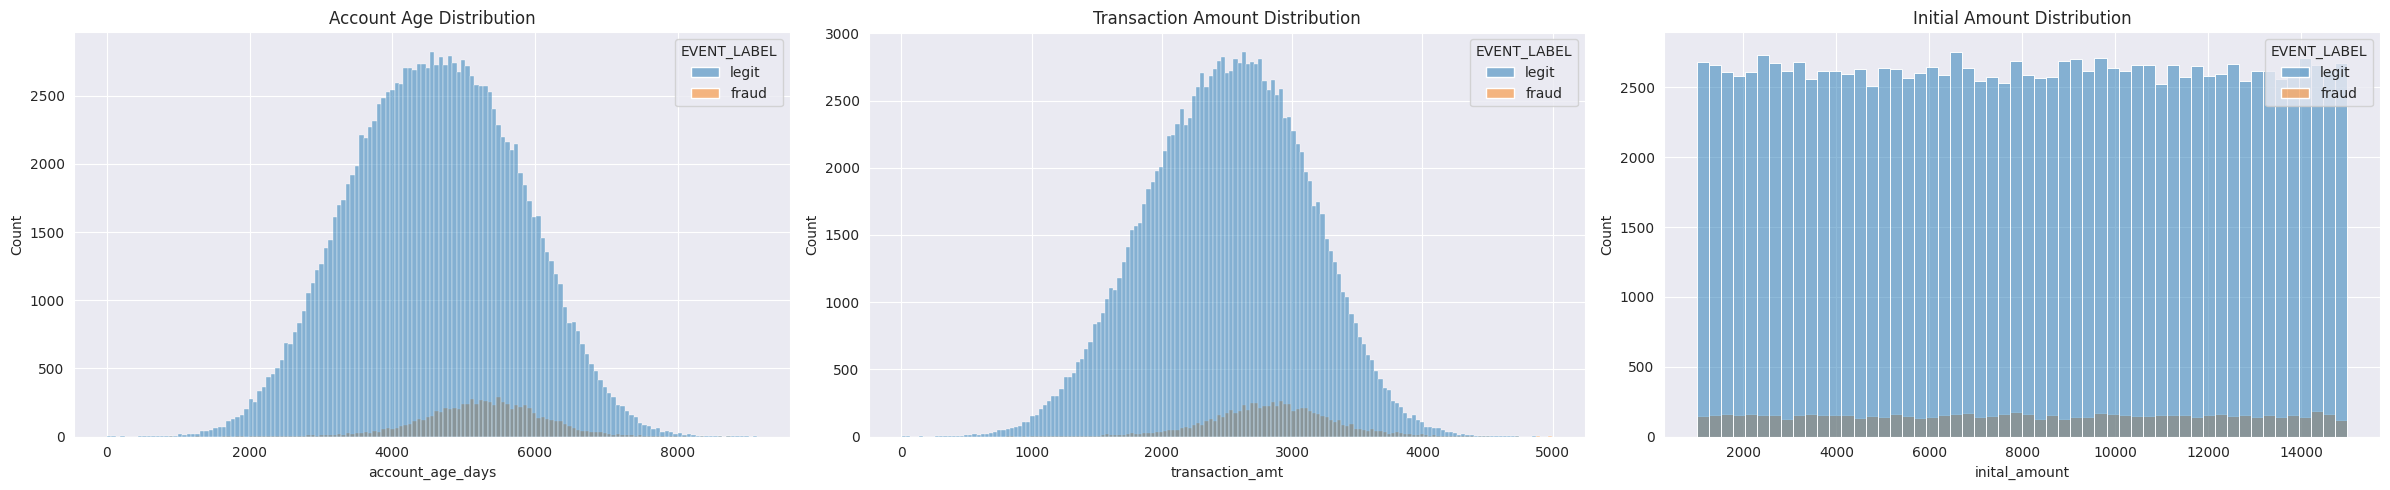

In [ ]:
#create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(24, 5))

sns.histplot(data=df, x="account_age_days", hue="EVENT_LABEL", ax=axes[0])
axes[0].set_title('Account Age Distribution')

sns.histplot(data=df, x="transaction_amt", hue="EVENT_LABEL", ax=axes[1])
axes[1].set_title('Transaction Amount Distribution')

sns.histplot(data=df, x="inital_amount", hue="EVENT_LABEL", ax=axes[2])
axes[2].set_title('Initial Amount Distribution')

plt.tight_layout()
plt.show()


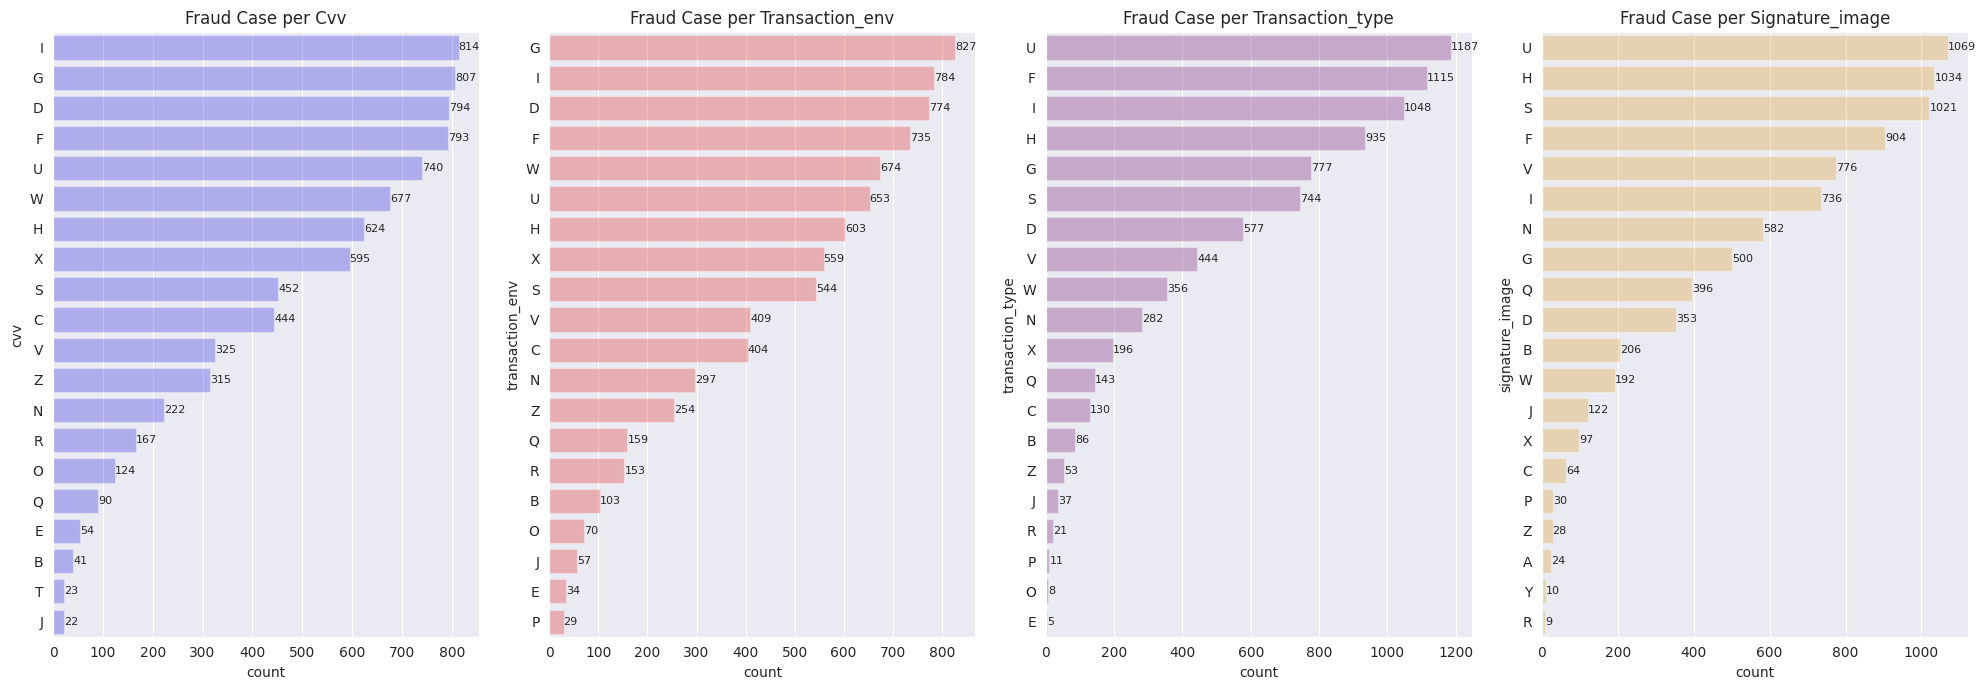

In [ ]:
features = ['cvv', 'transaction_env', 'transaction_type', 'signature_image']

#create a 1x4 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 7))

for i, feature in enumerate(features):
    transaction_env_count = df.groupby([feature, 'EVENT_LABEL']).size().reset_index(name='count')

    fraud_data = transaction_env_count[transaction_env_count['EVENT_LABEL'] == 'fraud'].sort_values(by='count', ascending=False)

    ax = sns.barplot(data=fraud_data.head(20), y=feature, x='count', color='blue' if i == 0 else 'red' if i == 1 else 'purple' if i == 2 else 'orange', alpha=0.3, ax=axes[i])
    ax.bar_label(ax.containers[0], fontsize=8)
    ax.set_title(f'Fraud Case per {feature.capitalize()}')

plt.tight_layout()
plt.show()

In [ ]:
df['user_agent_os'] = df['user_agent'].str.extract(r'\(([^)\s]+)', expand=True)

df['user_agent_os'] = df['user_agent_os'].str.replace(';', '')

df['user_agent_os'] = df['user_agent_os'].str.lower()

replacement_mapping = {
    'x11': 'linux',
    'macintosh': 'macos',
    'compatible': 'windows',
    'ipod': 'apple_device_os',
    'ipad': 'apple_device_os',
    'iphone': 'apple_device_os'
}
df['user_agent_os'] = df['user_agent_os'].replace(replacement_mapping, regex=True)

fraud_os_count = df[df['EVENT_LABEL'] == 'fraud'].groupby('user_agent_os').size().reset_index(name='count')

fig = px.pie(fraud_os_count, names='user_agent_os', values='count',
             title='User Agent OS in Fraud Events',
             opacity=0.8
             #,color_discrete_sequence=['blue', 'green'] * ((len(df_plotly) + 1) // 2)
             )

fig.update_layout(width=600, height=600)
fig.show()

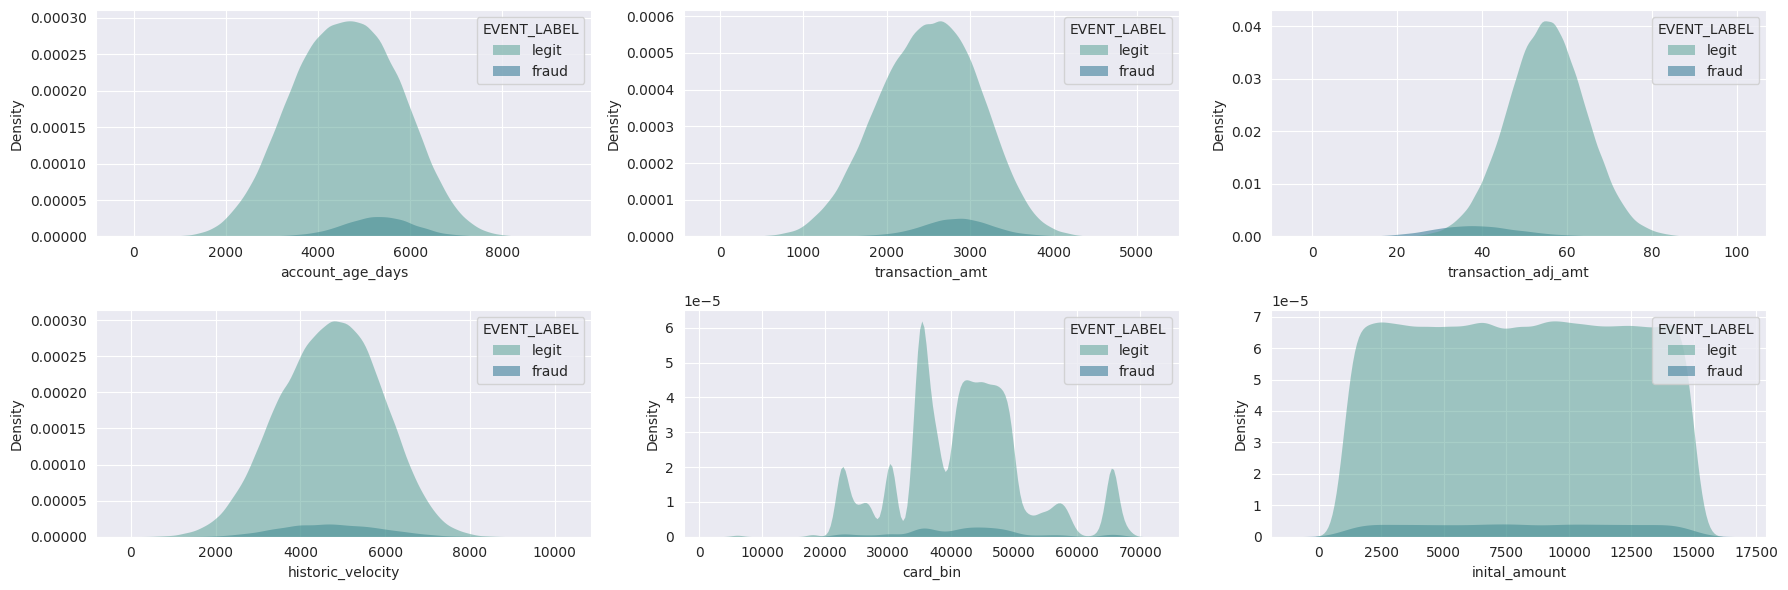

In [ ]:
columns = ["account_age_days", "transaction_amt", "transaction_adj_amt",
           "historic_velocity", "card_bin", "inital_amount"]

fig, axes = plt.subplots(2, 3, figsize=(18, 6))

axes = axes.flatten()
for i, column in enumerate(columns):
    sns.kdeplot(
        data=df, x=column, hue="EVENT_LABEL",
        fill=True, palette="crest", alpha=0.5, linewidth=0,
        ax=axes[i]
    )
    #axes[i].set_title(column)


plt.tight_layout()
plt.show()


In [ ]:
df['EVENT_TIMESTAMP'] = pd.to_datetime(df['EVENT_TIMESTAMP'])
df['EVENT_TIME'] = df['EVENT_TIMESTAMP'].dt.strftime('%H:%M:%S')
df['EVENT_DATE'] = df['EVENT_TIMESTAMP'].dt.date

In [ ]:
t_df = df[['EVENT_TIMESTAMP', 'EVENT_TIME', 'EVENT_LABEL', 'EVENT_DATE']]

<Axes: xlabel='EVENT_DATE', ylabel='Count'>

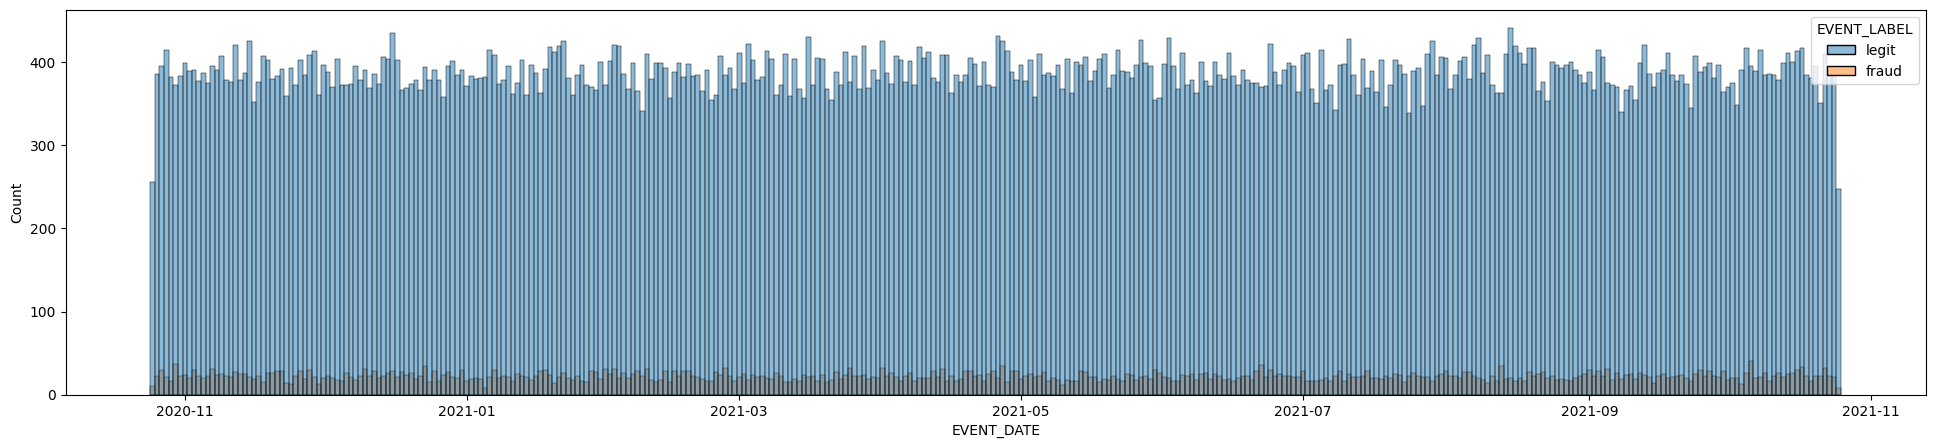

In [ ]:
plt.figure(figsize=(24, 5))
sns.histplot(data=t_df.sort_values('EVENT_TIME'), x="EVENT_DATE", hue="EVENT_LABEL")

#Data Transformation

N.B: XGBoost supports missing values by default. In tree algorithms, branch directions for missing values are learned during training. Therefore, no approach has been taken to handle the missing values.

In [ ]:
p_df = df.copy()

In [ ]:
#data selection
columns_to_drop = ['ip_address', 'user_agent', 'email_domain',
                   'phone_number', 'billing_postal',
                   'card_bin',
                   'EVENT_TIMESTAMP',
                   'applicant_name', 'billing_address', 'merchant_id',
                   'locale', 'tranaction_initiate',
                   'EVENT_TIME', 'EVENT_DATE']

p_df = p_df.drop(columns=columns_to_drop, axis = 1)

In [ ]:
#label encoding
columns_to_label_encode = ['billing_city',
                           'cvv', 'currency',
                           'signature_image', 'transaction_type', 'transaction_env',
                           'user_agent_os']

label_encoder = LabelEncoder()

for column in columns_to_label_encode:
    p_df[column] = label_encoder.fit_transform(p_df[column])


p_df['EVENT_LABEL'] = p_df['EVENT_LABEL'].replace({'legit': 1, 'fraud': 0})

In [ ]:
#one-hot-encoding
billing_state_ = pd.get_dummies(df['billing_state']).astype('int')

p_df = pd.concat([p_df, billing_state_], axis=1)
p_df = p_df.drop('billing_state', axis = 1)

In [ ]:
#correlation check
_corr = p_df.corr()
_corr['EVENT_LABEL'].sort_values(ascending = False)

EVENT_LABEL            1.000000
transaction_adj_amt    0.363962
transaction_type       0.014087
Kentucky               0.007634
Massachusetts          0.005424
                         ...   
transaction_env       -0.009204
signature_image       -0.009757
currency              -0.021351
transaction_amt       -0.123820
account_age_days      -0.130950
Name: EVENT_LABEL, Length: 64, dtype: float64

##Model Building

In [ ]:
#separating labels and features
X = p_df.drop('EVENT_LABEL', axis = 1)
y = p_df['EVENT_LABEL']

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
xgbc = xgb.XGBClassifier(tree_method = 'hist',n_jobs = 6, random_state = 10)

param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=xgbc, param_grid=param_grid, scoring='average_precision', cv=cv,verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 9 folds for each of 81 candidates, totalling 729 fits
[CV 1/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.987 total time=   1.4s
[CV 2/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.990 total time=   1.4s
[CV 3/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.990 total time=   1.3s
[CV 4/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.987 total time=   1.3s
[CV 5/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.990 total time=   1.4s
[CV 6/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.989 total time=   1.3s
[CV 7/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.990 total time=   1.3s
[CV 8/9] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8;, score=0.991 total time=   2.2s
[CV 9/9] END learning_rate=0.01, max_depth=3, n_estimators

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=1),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importan...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=6, num_parallel_tree=None,
                                     random_state=10, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='average_precision', verbose=3)

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

#best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
best_model = grid_search.best_estimator_

_y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, _y_pred)
print(f"Accuracy on Test Set: {np.round(accuracy,3)}")

Accuracy on Test Set: 0.982


In [ ]:
import pickle
filename = 'final_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

In [ ]:
print('Classification Report:')
print(classification_report(y_test, _y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.82      1633
           1       0.98      1.00      0.99     28367

    accuracy                           0.98     30000
   macro avg       0.95      0.87      0.90     30000
weighted avg       0.98      0.98      0.98     30000



In [ ]:
_precision = metrics.precision_score(y_test,_y_pred)
_recall = metrics.recall_score(y_test,_y_pred)
_f1_score = metrics.f1_score(y_test,_y_pred)

print('Precision on testing data is:', np.round(_precision,3))
print('Recall on testing data is:', np.round(_recall,3))
print('F1 score on testing data is:', np.round(_f1_score,3))

Precision on testing data is: 0.985
Recall on testing data is: 0.996
F1 score on testing data is: 0.991


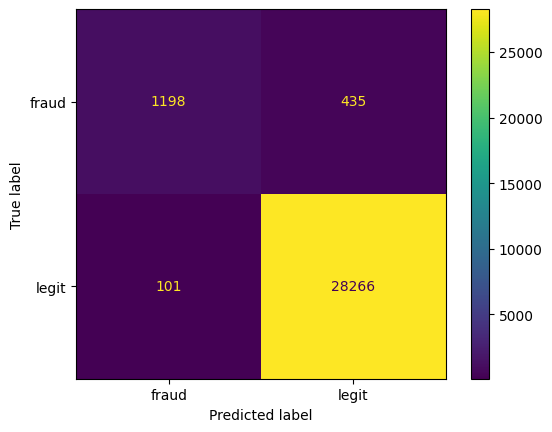

In [ ]:
#confusion matrix plot
confusion_matrix = metrics.confusion_matrix(y_test,_y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix
                                    ,display_labels=['fraud','legit']
                                    )
cm.plot()
plt.show()

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, _y_pred).ravel()
print(f'TP: {tp} \nTN: {tn} \nFP: {fp} \nFN: {fn}')

TP: 28266 
TN: 1198 
FP: 435 
FN: 101


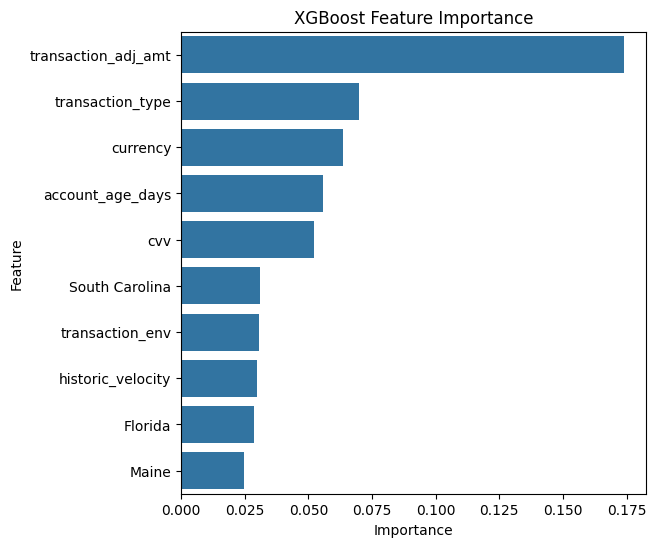

In [ ]:
feature_importance = best_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('XGBoost Feature Importance')
plt.show()

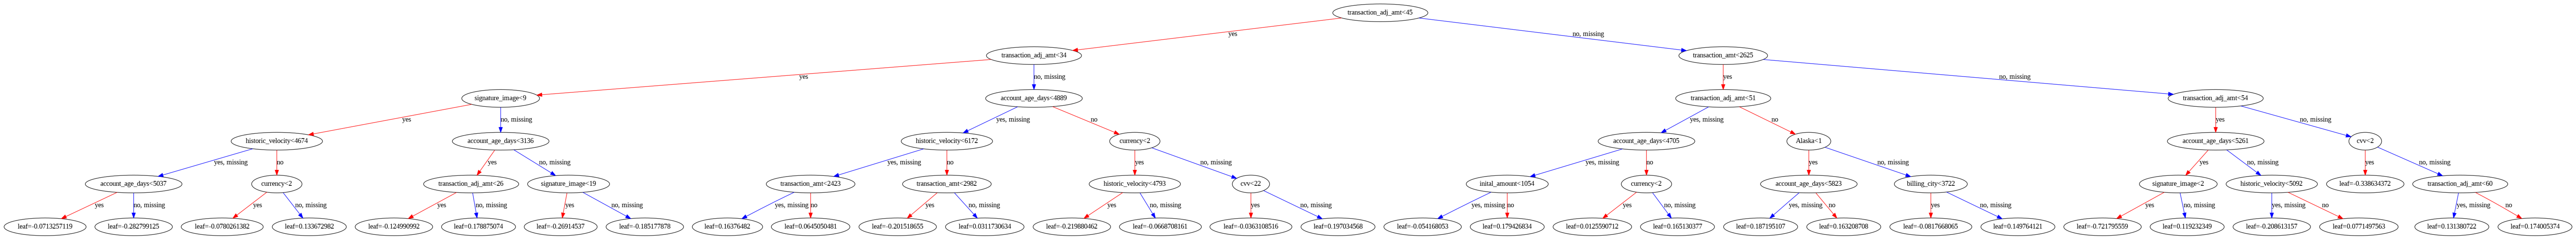

In [ ]:
xgb.plot_tree(best_model, num_trees=6)
fig = plt.gcf()
fig.set_size_inches(150, 100)

##Shap Analysis

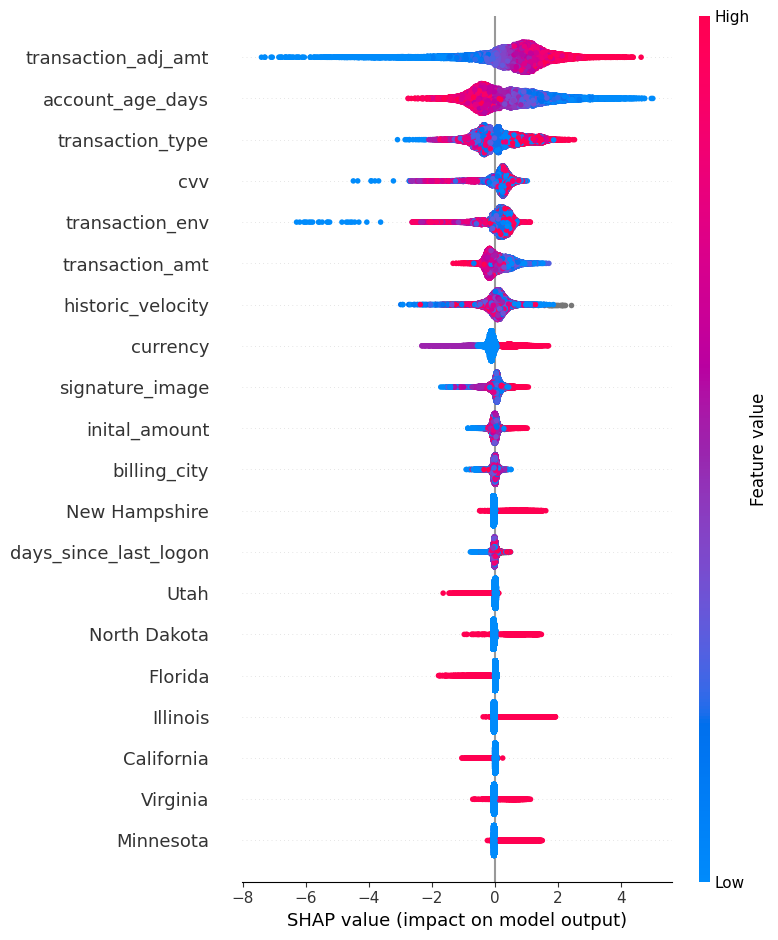

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test)

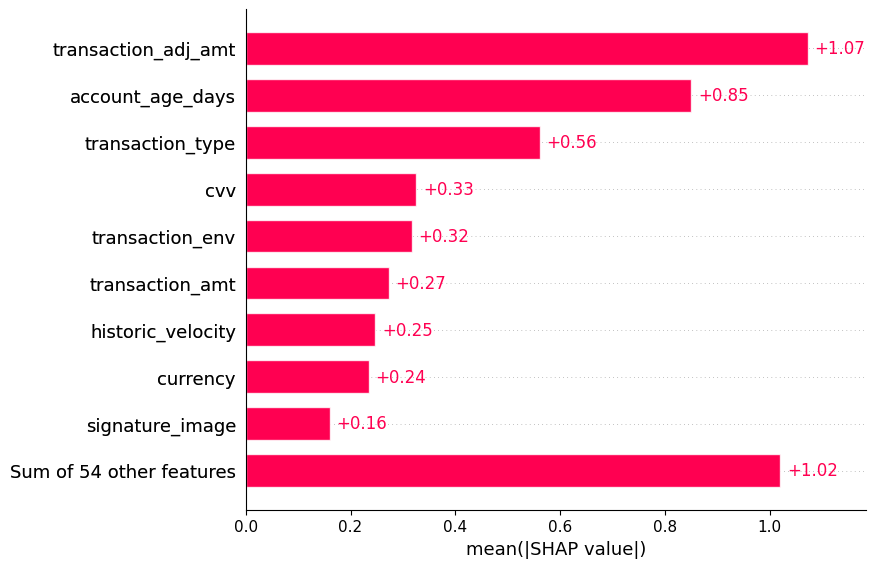

In [ ]:
#Show the importance of parameters
values = explainer(X_test)
shap.plots.bar(values)